# Continuous Control

In this notebook, I show the DDPG algorithm I implemented to solve the Reach environment. This notebook correspond to the second project of the the Udacity deep learning nanodegree program [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. Be careful, to download the multi-agent environment.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

In [2]:
env = UnityEnvironment(file_name='../../Reacher_Linux/Reacher.x86',seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# Here we take the brain name  and set it as the default
# Environments contain brains which are responsible for deciding the actions of their associated agents
# We use a 20 agents. Each of them is independant.They dont interact in the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Train the agents

In the next code cells, you can found the body of the training code I implemented. It uses the Python API to control the agent and receive feedback from the environment.

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

### Define training function

In [6]:
def ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent,n_episodes=6000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = [] # list containing a score vector of the 20 agents from each episode 
    score_mean=[] # list containing the mean score for each episode
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
           # actions = agent.act(states)
            actions = [agent.act(states[i],rate=0.9999) for i in range(num_agents)] # vector of new action to take for each agent detmined by the ddpg algo

            env_info = env.step(actions)[brain_name]  # information about the environment 
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done # see if episode finished

            agent.step(states, actions, rewards, next_states, dones,num_agents) # DDPG algorythm: learning process, update weights for the actor-critic network, etc
            states = next_states # roll over the state to next time step
            score =score+ rewards # update the score for each agent
            if any(dones):  # see if episode has finished for agent. if yes, we stop for all agent. 
                break
        score_mean.append(np.mean(score))  # save mean score (dim =1)     
        scores.append(score)# save most recent score for each agent (list of list)
        scores_deque.append(score)# save most recent score for each agent (list(dim=100) of list (20 agents score),)
        print('\rEpisode {} Average Score deque: {} Average score: {}'.format(i_episode, np.mean(scores_deque),np.mean(score)), end="")
        if i_episode>100 and np.mean(scores_deque)>30.:
            print("envionment solved")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save weight for actor
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save weight for critic
            return scores,score_mean
    return scores,score_mean

scores,score_mean = ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent)



Episode 135 Average Score deque: 30.192024325155653 Average score: 38.04449914963916envionment solved


### Display results for training

#### Score for each agent

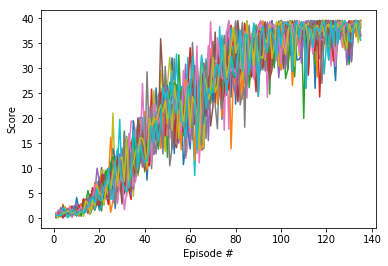

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Mean score (over all agents)

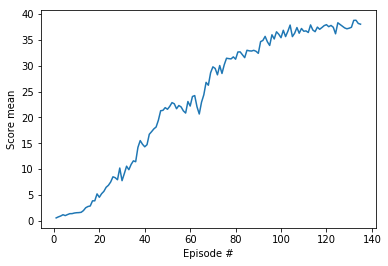

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score_mean)+1), score_mean)
plt.ylabel('Score mean')
plt.xlabel('Episode #')
plt.show()

## Finish training
close the environment

In [9]:
env.close()

# Test

### Load libraries

In [10]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from agent import Agent

### Define testing function

In [11]:
def Test(env,brain_name,agent,file_name_actor,file_name_critic,n_episodes=10, max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    agent.actor_local.load_state_dict(torch.load(file_name_actor))
    agent.critic_local.load_state_dict(torch.load(file_name_critic)) 
    scores = [] # list containing scores from each episode for each agent                      
    score_mean = [] # list containing mean score from each episode 
    score = 0
    
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations 
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = [agent.act(states[i],rate=0.9999) for i in range(num_agents)] # vector of action for each agent.
            env_info = env.step(actions)[brain_name] # environment informations
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            states = next_states  # roll over the state to next time step
            score =score+ rewards # update the score for each agent
            if any(dones): # see if episode has finished
                break
        score_mean.append(np.mean(score))  # save mean score for all agent       
        scores.append(score) # save score for each agent     
        print('\rEpisode {} Average Score: {}'.format(i_episode, np.mean(scores)), end="")

    return scores,score_mean

### Load environement

In [13]:
env = UnityEnvironment(file_name='../../Reacher_Linux/Reacher.x86',seed=0)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [14]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

### Load the weights

In [15]:
file_name_actor ='checkpoint_actor.pth'
file_name_critic ='checkpoint_critic.pth'

### Run test

In [ ]:
scores,score_mean =Test(env,brain_name,agent,file_name_actor,file_name_critic ,n_episodes=10,max_t=1000)

Episode 8 Average Score: 38.542374138510795

### Display score

#### Score for each agent

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Mean score

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score_mean)+1), score_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### End for testing
Close the environment

In [ ]:
env.close()